# Predicting the solubility of molecules

#### End-to-End cheminformatics project

This project uses the work published by [John S. Delaney](https://pubs.acs.org/doi/10.1021/ci034243x) including using the [data set](https://pubs.acs.org/doi/suppl/10.1021/ci034243x/suppl_file/ci034243xsi20040112_053635.txt) provided in this publication.

Requires the installation of RDKit - a versatile and open-source cheminformatics toolkit

#### General Solubility Equation

The General Solubility Equation (GSE) was defined by [Yalkowsky](https://jpharmsci.org/article/S0022-3549(16)30715-8/fulltext) in his widely cited paper is given as:

logS =  0.5 - 0.01(MP - 25) - log(LogP)

where, logS is the aqueous solubility and MP is the melting point in degrees Celsius.

The issue here is that it is very hard to predict the MP of a molecule. This is the main reason for using ML models, based on semi-emperical solubility equations, to predict solubility of molecules.

In Delaney's work, the **LogS** (log of the aqueous solubility) is predicted using the following 4 molecular descriptors.

1. **LogP** *(Octanol-water partition coefficient)*
2. **MW** *(Molecular weight)*
3. **RB** *(Number of rotatable bonds)*
4. **AP** *(Aromatic proportion = number of aromatic atoms / total number of heavy atoms)*

Of these, the first three are readily computed by rdkit (using the `Descriptors` method), while for the 4th, rdkit can calculate the individual components, i.e., *number of aromatic atoms* and *total number of heavy atoms*.

Delaney used Linear Regression to obtain the following coefficients which describe the solubility in terms of these descriptors:

LogS = 0.16 -  0.63 LogP - 0.0062 MW + 0.066 RB - 0.74 AP


**In this project, we start by using the same method as Delaney and then follow it up with other techniques to see if we can predict the solubility of molecules better.**

In [1]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem

In [2]:
# Read the CSV file
df = pd.read_csv('ci034243xsi20040112_053635.txt')
df

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.180,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.000,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.740,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.480,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.040,-3.077,FC(F)(Cl)C(F)(Cl)Cl
...,...,...,...,...
1139,vamidothion,1.144,-1.446,CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140,Vinclozolin,-4.925,-4.377,CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141,Warfarin,-3.893,-3.913,CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O
1142,Xipamide,-3.790,-3.642,Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O


The molecular structures are represented in the SMILES format - Simplified Molecular-Input Line-Entry System

In [3]:
df.SMILES

0                                    ClCC(Cl)(Cl)Cl
1                                      CC(Cl)(Cl)Cl
2                                    ClC(Cl)C(Cl)Cl
3                                        ClCC(Cl)Cl
4                               FC(F)(Cl)C(F)(Cl)Cl
                           ...                     
1139                   CNC(=O)C(C)SCCSP(=O)(OC)(OC)
1140          CC1(OC(=O)N(C1=O)c2cc(Cl)cc(Cl)c2)C=C
1141         CC(=O)CC(c1ccccc1)c3c(O)c2ccccc2oc3=O 
1142    Cc1cccc(C)c1NC(=O)c2cc(c(Cl)cc2O)S(N)(=O)=O
1143                         CNC(=O)Oc1cc(C)cc(C)c1
Name: SMILES, Length: 1144, dtype: object

We need to convert these SMILES (which are strings) to an rdkit object

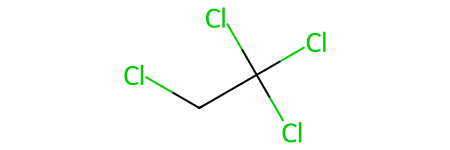

In [4]:
mol1 = Chem.MolFromSmiles(df.SMILES[0])
mol1

In [5]:
mol_all = [Chem.MolFromSmiles(smi) for smi in df.SMILES]
len(mol_all)  # Number of molecules

1144

In [6]:
from rdkit.Chem import Descriptors

We start by creating methods to calculate these descriptors.

In [7]:
# Method to calculate the octanol-water partition coefficient (cLogP) for a single molecule or list of molecules
def calculate_cLogP(mol,n=2):
    """Calculate the octanol-water partition coefficient (cLogP) for a single molecule or a list of molecules.

    The method, by default is for a list of molecules, but can also be used for a single molecule by passing `n=1`."""
    if n == 1:
        return Descriptors.MolLogP(mol)
    elif n > 1:
        return [Descriptors.MolLogP(m) for m in mol]

# print(calculate_cLogP(mol1,1))
# print(calculate_cLogP(mol_all))

# Method to calculate the molecular weight (MW) for a list of molecules
def calculate_MW(mol,n=2):
    """Calculate the molecular weight (MW) for a single molecule or a list of molecules."""
    if n == 1:
        return Descriptors.MolWt(mol)
    elif n > 1:
        return [Descriptors.MolWt(m) for m in mol]
    
# Method to calculate the number of rotatable bonds (RB) for a list of molecules
def calculate_RB(mol,n=2):
    """Calculate the number of rotatable bonds (RB) for a single molecule or a list of molecules."""
    if n == 1:
        return Descriptors.NumRotatableBonds(mol)
    elif n > 1:
        return [Descriptors.NumRotatableBonds(m) for m in mol]
    
# Method to calculate the aromatic proportion (AP) for a list of molecules
def calculate_AP(mol,n=2):
    """Calculate the aromatic proportion (AP) for a single molecule or a list of molecules."""
    if n == 1:
        num_aromatic_atoms = len(mol.GetAromaticAtoms())
        num_heavy_atoms = mol.GetNumHeavyAtoms()
        return num_aromatic_atoms / num_heavy_atoms if num_heavy_atoms > 0 else 0
    elif n > 1:
        return [calculate_AP(m,1) for m in mol]

Let us now create a dataframe that includes the values of these descritors for all molecules in our dataset.

This is basically our **X Matrix**

In [8]:
columns = ['cLogP', 'MW', 'RB', 'AP']
df_descriptors = pd.DataFrame(data={
    'cLogP': calculate_cLogP(mol_all),
    'MW': calculate_MW(mol_all),
    'RB': calculate_RB(mol_all),
    'AP': calculate_AP(mol_all)
},columns=columns)

df_descriptors

,cLogP,MW,RB,AP
0,2.59540,167.850,0,0.000000
1,2.37650,133.405,0,0.000000
2,2.59380,167.850,1,0.000000
3,2.02890,133.405,1,0.000000
4,2.91890,187.375,1,0.000000
...,...,...,...,...
1139,1.98820,287.343,8,0.000000
1140,3.42130,286.114,2,0.333333
1141,3.60960,308.333,4,0.695652
1142,2.56214,354.815,3,0.521739


We will now define our **Y matrix**, or the solution as the calculated values of **LogS**

In [9]:
Y = df.iloc[:,1]
Y

0      -2.180
1      -2.000
2      -1.740
3      -1.480
4      -3.040
        ...  
1139    1.144
1140   -4.925
1141   -3.893
1142   -3.790
1143   -2.581
Name: measured log(solubility:mol/L), Length: 1144, dtype: float64

### Splitting the data

We now have everything we need in terms of data - i.e., the table fo descriptors and the solution.

Now, we need to split this data into sets (training, and testing) before we apply our machine learning models

In [10]:
from sklearn.model_selection import train_test_split

Now we break the set into a training set (which includes 80% of the data) and a test set with the remaining 20% of the data.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(df_descriptors, Y, test_size=0.2)

## Linear Regression



First, we start with simple linear regression and fit using the training set.

In [12]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

Then, we inspect the coefficients to ensure that they are sensible. This will also give us chemical insights like:

-  Which descriptors contribute most.
-  Whether the effect is positive (increasing solubility) or negative (decreasing solubility).

In [13]:
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)

Coefficients: [-0.73738504 -0.00661441 -0.00622465 -0.42892043]
Intercept: 0.2900284214150184


Here, it is worth comparing these coefficients with those obtained by Delaney.

LogS = 0.16 -  0.63 LogP - 0.0062 MW + 0.066 RB - 0.74 AP

We see from the coefficients printed above that they are not exactly the same as those in the equation given by Delaney. This is likely due to different way of calculating the descriptors compared to Delaney.

However, it is also encouraging that the signs are consistent.

It is also worth checking how the model performs when applied on the training set.

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

Y_pred_train = model.predict(X_train)

train_error = mean_squared_error(Y_train, Y_pred_train)
train_r2 = r2_score(Y_train, Y_pred_train)

print('Mean squared error (MSE): %.2f' % train_error)
print('Coefficient of determination (R^2): %.2f' % train_r2)

Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


Finally, it is time to test the model on the test set and see how it does.

In [15]:
Y_pred_test = model.predict(X_test)

test_error = mean_squared_error(Y_test, Y_pred_test)
test_r2 = r2_score(Y_test, Y_pred_test)

print('Mean squared error (MSE): %.2f' % test_error)
print('Coefficient of determination (R^2): %.2f' % test_r2)

Mean squared error (MSE): 1.01
Coefficient of determination (R^2): 0.77


#### Analysis of errors

We can compare the errors between the training and test sets.

-  Small gap - good fit (model generalizes well).
-  Large gap - overfitting (model too complex).
-  Both errors high - underfitting (model too simple).

Now, for some fun stuff. Plots!!

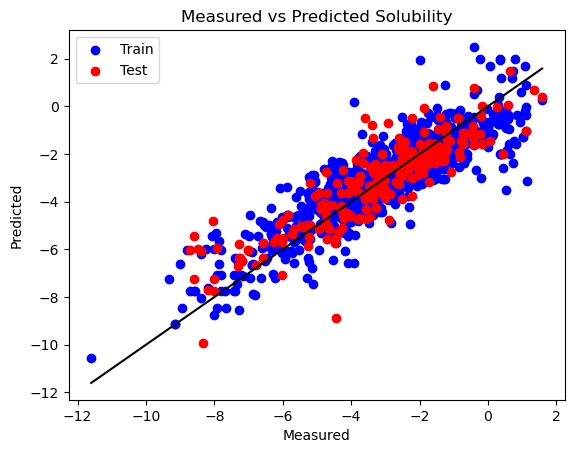

In [47]:
import matplotlib.pyplot as plt

plt.scatter(Y_train, Y_pred_train, color='blue', label='Train')
plt.scatter(Y_test, Y_pred_test, color='red', label='Test')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k-')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Solubility')
plt.legend()
plt.savefig('plot_measured_vs_predicted.png')

Let us now try some other regression methods.

## Ridge (L2) Linear Regression

In [18]:
model2 = linear_model.Ridge()
model2.fit(X_train, Y_train)

Ridge()

In [19]:
print('Coefficients:', model2.coef_)
print('Intercept:', model2.intercept_)

Coefficients: [-0.73731136 -0.00661863 -0.00599605 -0.42450969]
Intercept: 0.2886397857157066


In [39]:
Y_pred_train2 = model2.predict(X_train)

train_error2 = mean_squared_error(Y_train, Y_pred_train2)
train_r2_2 = r2_score(Y_train, Y_pred_train2)

print('Mean squared error (MSE) Ridge: %.2f' % train_error2)
print('Coefficient of determination (R^2) Ridge: %.2f' % train_r2_2)

Mean squared error (MSE) Ridge: 1.01
Coefficient of determination (R^2) Ridge: 0.77


In [40]:
Y_pred_test2 = model2.predict(X_test)
test_error2 = mean_squared_error(Y_test, Y_pred_test2)
test_r2_2 = r2_score(Y_test, Y_pred_test2)  

print('Mean squared error (MSE) Ridge: %.2f' % test_error2)
print('Coefficient of determination (R^2) Ridge: %.2f' % test_r2_2)

Mean squared error (MSE) Ridge: 1.01
Coefficient of determination (R^2) Ridge: 0.77


## Lasso

In [24]:
model3 = linear_model.Lasso()
model3.fit(X_train, Y_train)

print('Coefficients:', model3.coef_)
print('Intercept:', model3.intercept_)

Coefficients: [-0.40398046 -0.00941755  0.         -0.        ]
Intercept: -0.11027371139843156


In [25]:
Y_pred_train3 = model3.predict(X_train)

train_error3 = mean_squared_error(Y_train, Y_pred_train3)
train_r2_3 = r2_score(Y_train, Y_pred_train3)

print('Mean squared error (MSE) Lasso: %.2f' % train_error3)
print('Coefficient of determination (R^2) Lasso: %.2f' % train_r2_3)

Mean squared error (MSE) Lasso: 1.38
Coefficient of determination (R^2) Lasso: 0.69


## Elastic Net Linear Regression

In [26]:
model4 = linear_model.SGDRegressor()
model4.fit(X_train, Y_train)
print('Coefficients:', model4.coef_)
print('Intercept:', model4.intercept_)

Coefficients: [ 1.16241186e+11 -4.92261436e+10 -9.01274568e+10 -3.01856965e+10]
Intercept: [-7.64622494e+10]


In [27]:
Y_pred_train4 = model4.predict(X_train)
train_error4 = mean_squared_error(Y_train, Y_pred_train4)
train_r2_4 = r2_score(Y_train, Y_pred_train4)
print('Mean squared error (MSE) SGDRegressor: %.2f' % train_error4)
print('Coefficient of determination (R^2) SGDRegressor: %.2f' % train_r2_4)

Mean squared error (MSE) SGDRegressor: 126950621186813612137644032.00
Coefficient of determination (R^2) SGDRegressor: -28929009000384269094223872.00


## Gradient Boosting for regression

In [28]:
from sklearn import ensemble
model5 = ensemble.GradientBoostingRegressor()

model5.fit(X_train, Y_train)
print('Feature importances:', model5.feature_importances_)

Feature importances: [0.87320013 0.10821059 0.00507871 0.01351057]


In [29]:
Y_pred_train5 = model5.predict(X_train)
train_error5 = mean_squared_error(Y_train, Y_pred_train5)
train_r2_5 = r2_score(Y_train, Y_pred_train5)
print('Mean squared error (MSE) Gradient Boosting: %.2f' % train_error5)
print('Coefficient of determination (R^2) Gradient Boosting: %.2f' % train_r2_5)

Mean squared error (MSE) Gradient Boosting: 0.36
Coefficient of determination (R^2) Gradient Boosting: 0.92


In [38]:
GBR_score = model5.score(X_train, Y_train)
print('Gradient Boosting Regressor Score: %.2f' % GBR_score)

Gradient Boosting Regressor Score: 0.92


In [41]:
Y_pred_test5 = model5.predict(X_test)
test_error5 = mean_squared_error(Y_test, Y_pred_test5)
test_r2_5 = r2_score(Y_test, Y_pred_test5)
print('Mean squared error (MSE) Gradient Boosting: %.2f' % test_error5)
print('Coefficient of determination (R^2) Gradient Boosting: %.2f' % test_r2_5)

Mean squared error (MSE) Gradient Boosting: 0.54
Coefficient of determination (R^2) Gradient Boosting: 0.88


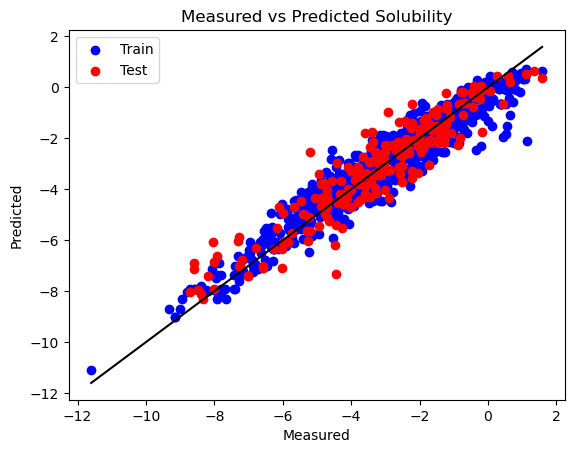

In [49]:
plt.scatter(Y_train, Y_pred_train5, color='blue', label='Train')
plt.scatter(Y_test, Y_pred_test5, color='red', label='Test')
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k-')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted Solubility')
plt.legend()
plt.savefig('plot_measured_vs_predicted_5.png')